# Import python packages for pipeline

In [25]:
from Bio import SeqIO
import subprocess
import platform
import shutil
import os

# Install external softwares

In [ ]:
# Try to install the external programs automatically
try:
    if shutil.which("mmseqs") is None:
        subprocess.run("conda install -c conda-forge -c bioconda mmseqs2", shell=True)
        print("mmseqs2 not installed")
    elif shutil.which("mmseqs") is not None:
        print("mmseqs2 already installed: ", shutil.which("mmsa"))
except:
    print("Was not able to install mmseqs2 automatically. Please install manually")
    
try:
    if "macOS" in platform.platform() and shutil.which("mafft") is None:
        subprocess.run("brew install mafft", shell=True)
        print("mafft not installed")
    elif "Linux" in platform.platform() and shutil.which("mafft") is None:
        print("mafft not installed: ", shutil.which("mafft"))
    else:
        print("mafft already installed: ", shutil.which("mafft"))
except:
    print("Was not able to install mafft automatically. Please install manually")

try:
    if "macOS" in platform.platform() and shutil.which("FastTree") is None:
        subprocess.run("brew install fasttree", shell=True)
        print("FastTree not installed")
    elif "Linux" in platform.platform() and shutil.which("FastTree") is None:
        subprocess.run("sudo apt install fasttree", shell=True)
        print("FastTree not installed")
    else:
        print("FastTree already installed: ", shutil.which("mmsa"))
except:
    print("Was not able to install FastTree automatically. Please install manually")

try:
    if "macOS" in platform.platform() and shutil.which("paml") is None:
        subprocess.run("brew install paml", shell=True)
        print("FastTree not installed")
    elif "Linux" in platform.platform() and shutil.which("paml") is None:
        subprocess.run("sudo apt install paml", shell=True)
        print("FastTree not installed")
    else:
        print("FastTree already installed: ", shutil.which("mmsa"))
except:
    print("Was not able to install PAML automatically. Please install manually")

# Setup working directory and assign fasta input file

In [5]:
# path to fasta file
fasta_file = "/Users/dominiquefastus/master_project/NuStru/nustruDB/test_ddla_nucleotide.fasta"


# create tree structure for pipeline
cwd = os.getcwd()
if not os.path.exists(f'{cwd}/nustruTREE'):
    mkdir = os.mkdir(f'{cwd}/nustruTREE')
    mkdir = os.mkdir(f'{cwd}/nustruTREE/MSA')
    mkdir = os.mkdir(f'{cwd}/nustruTREE/TREE')
    
shutil.copy(fasta_file, f'{cwd}/nustruTREE/MSA')

# global variables
global working_dir 
global working_name
working_dir = f'{cwd}/nustruTREE/'
working_name = os.path.basename(fasta_file).split(".")[0]

# Run the sequence allignment with mmseqs2

In [ ]:
subprocess.run(f"mmseqs createdb {working_dir}/MSA/{working_name}.fasta {working_dir}/MSA/{working_name}.fasta.db", shell=True)
subprocess.run(f"mmseqs linclust {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/cluster {working_dir}/MSA/tmp --min-seq-id 0.9 -c 0.8 --cov-mode 1", shell=True)
subprocess.run(f"mmseqs result2msa {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/cluster {working_dir}/MSA/cluster.fasta --msa-format-mode 2", shell=True)

subprocess.run(f"mmseqs createseqfiledb {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/cluster {working_dir}/MSA/cluster_seq", shell=True)
subprocess.run(f"mmseqs result2flat {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/{working_name}.fasta.db  {working_dir}/MSA/cluster_seq {working_dir}/MSA/cluster_seq.fasta", shell=True)

In [ ]:
subprocess.run(f"mmseqs createsubdb {working_dir}/MSA/cluster {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/cluster_repr", shell=True)
subprocess.run(f"mmseqs convert2fasta {working_dir}/MSA/cluster_repr {working_dir}/MSA/cluster_repr.fasta", shell=True)

In [ ]:
subprocess.run("mmseqs align {working_dir}/MSA/cluster_repr {working_dir}/MSA/cluster_repr {working_dir}/MSA/cluster_repr {working_dir}/MSA/cluster_repr_aln", shell=True)
subprocess.run(f"mmseqs result2msa {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/{working_name}.fasta.db {working_dir}/MSA/cluster_repr_aln {working_dir}/MSA/cluster_repr.msa.fasta --msa-format-mode 2", shell=True)

# Run the sequence clustering with mafft

In [ ]:
subprocess.run(f"mafft --auto {working_dir}/MSA/{working_name}.fasta > {working_dir}/MSA/{working_name}_aligned.fasta", shell=True)
# subprocess.run(f"mafft --auto {working_dir}/MSA/test.fasta > {working_dir}/MSA/test_alligned.fasta", shell=True)

# Generate the phylogenetic tree with FastTree from MSA

In [ ]:
# subprocess.run(f"FastTree {working_dir}/MSA/{working_name}_alligned.fasta > {working_dir}/TREE/cluster_seq.tre", shell=True)
subprocess.run(f"FastTree {working_dir}/MSA/{working_name}_aligned.fasta > {working_dir}/TREE/{working_name}.tree", shell=True)

# Visualize the phylogenetic tree

In [ ]:
from ete3 import PhyloTree, EvolTree, TreeStyle

tree = PhyloTree(f"{working_dir}/TREE/test_ddla_protein.tree")
alignment = (f"{working_dir}/MSA/test_ddla_nucleotide.fasta")

ecoli_ddla_leaf = tree.get_leaves_by_name("P0A6J8")[0]
ecoli_subtree = ecoli_ddla_leaf.up.up.up.up.up.up
# lca = ecoli_subtree.get_common_ancestor(t)
ecoli_subtree.set_outgroup( ecoli_subtree&"A0A6M9WZ03" )

ecoli_subtree.link_to_alignment(alignment)
ts = TreeStyle()

# ecoli_subtree.render(file_name="%%inline", w=1400, tree_style=ts)
# ecoli_subtree.show(tree_style=ts)

#### Evolutionary hypothesis testing

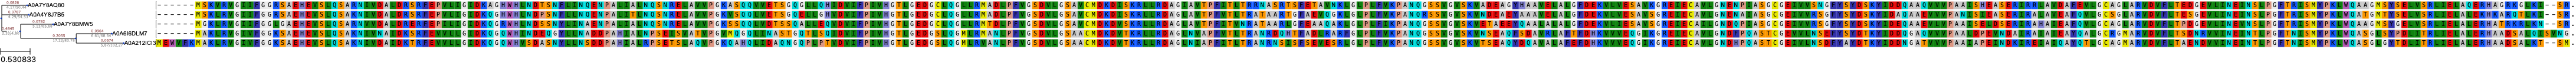

In [19]:
tree = EvolTree(f"{working_dir}/TREE/test_ddla_protein.tree")
alignment = (f"{working_dir}/MSA/test_ddla_nucleotide_aligned.fasta")
tree.link_to_alignment(alignment)

tree.workdir = f"{working_dir}/TREE/"
best_model = None
best_lnl   = float('-inf')


tree.run_model('fb.example')
my_first_fb_model = tree.get_evol_model('fb.example')

from ete3.treeview.layouts import evol_clean_layout
ts = TreeStyle()
# tree.show(layout=evol_clean_layout)
tree.render(file_name="%%inline", tree_style=ts, layout=evol_clean_layout)

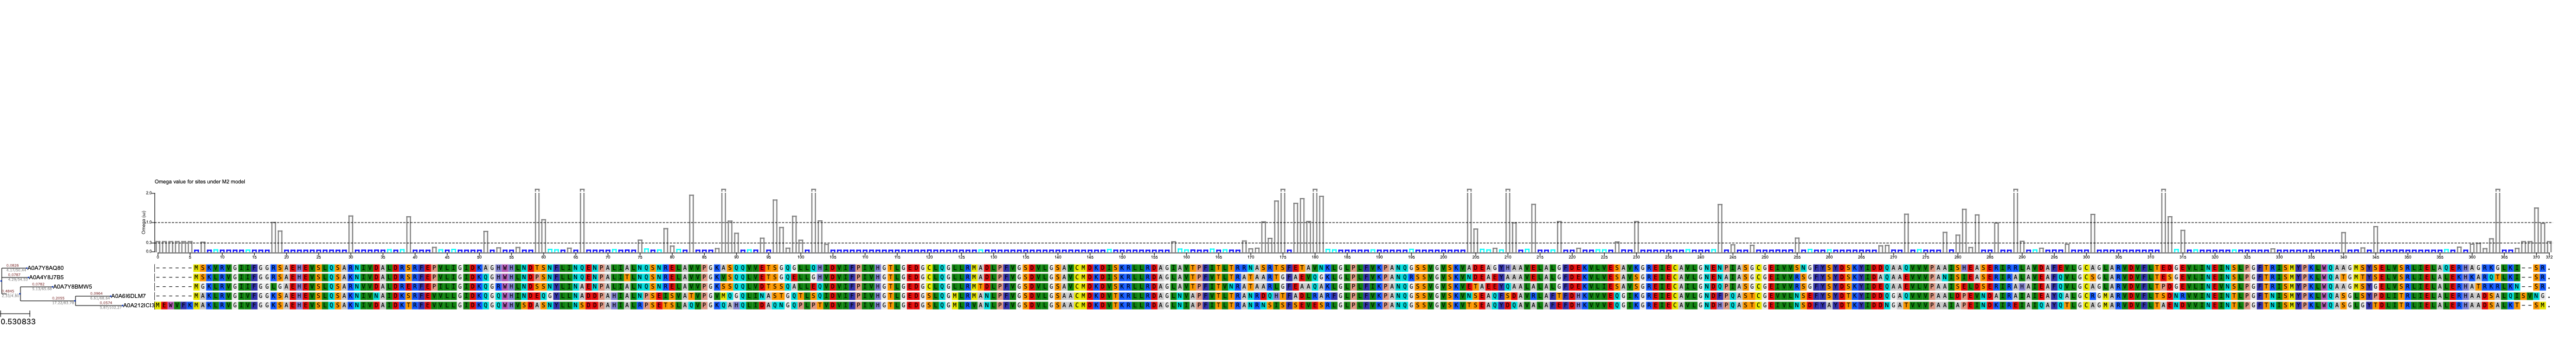

In [18]:
tree.run_model('M2')

# tree.show(layout=evol_clean_layout, histfaces=["M2"])
tree.render(file_name="%%inline", tree_style=ts, layout=evol_clean_layout, histfaces=["M2"])

#### Other trees

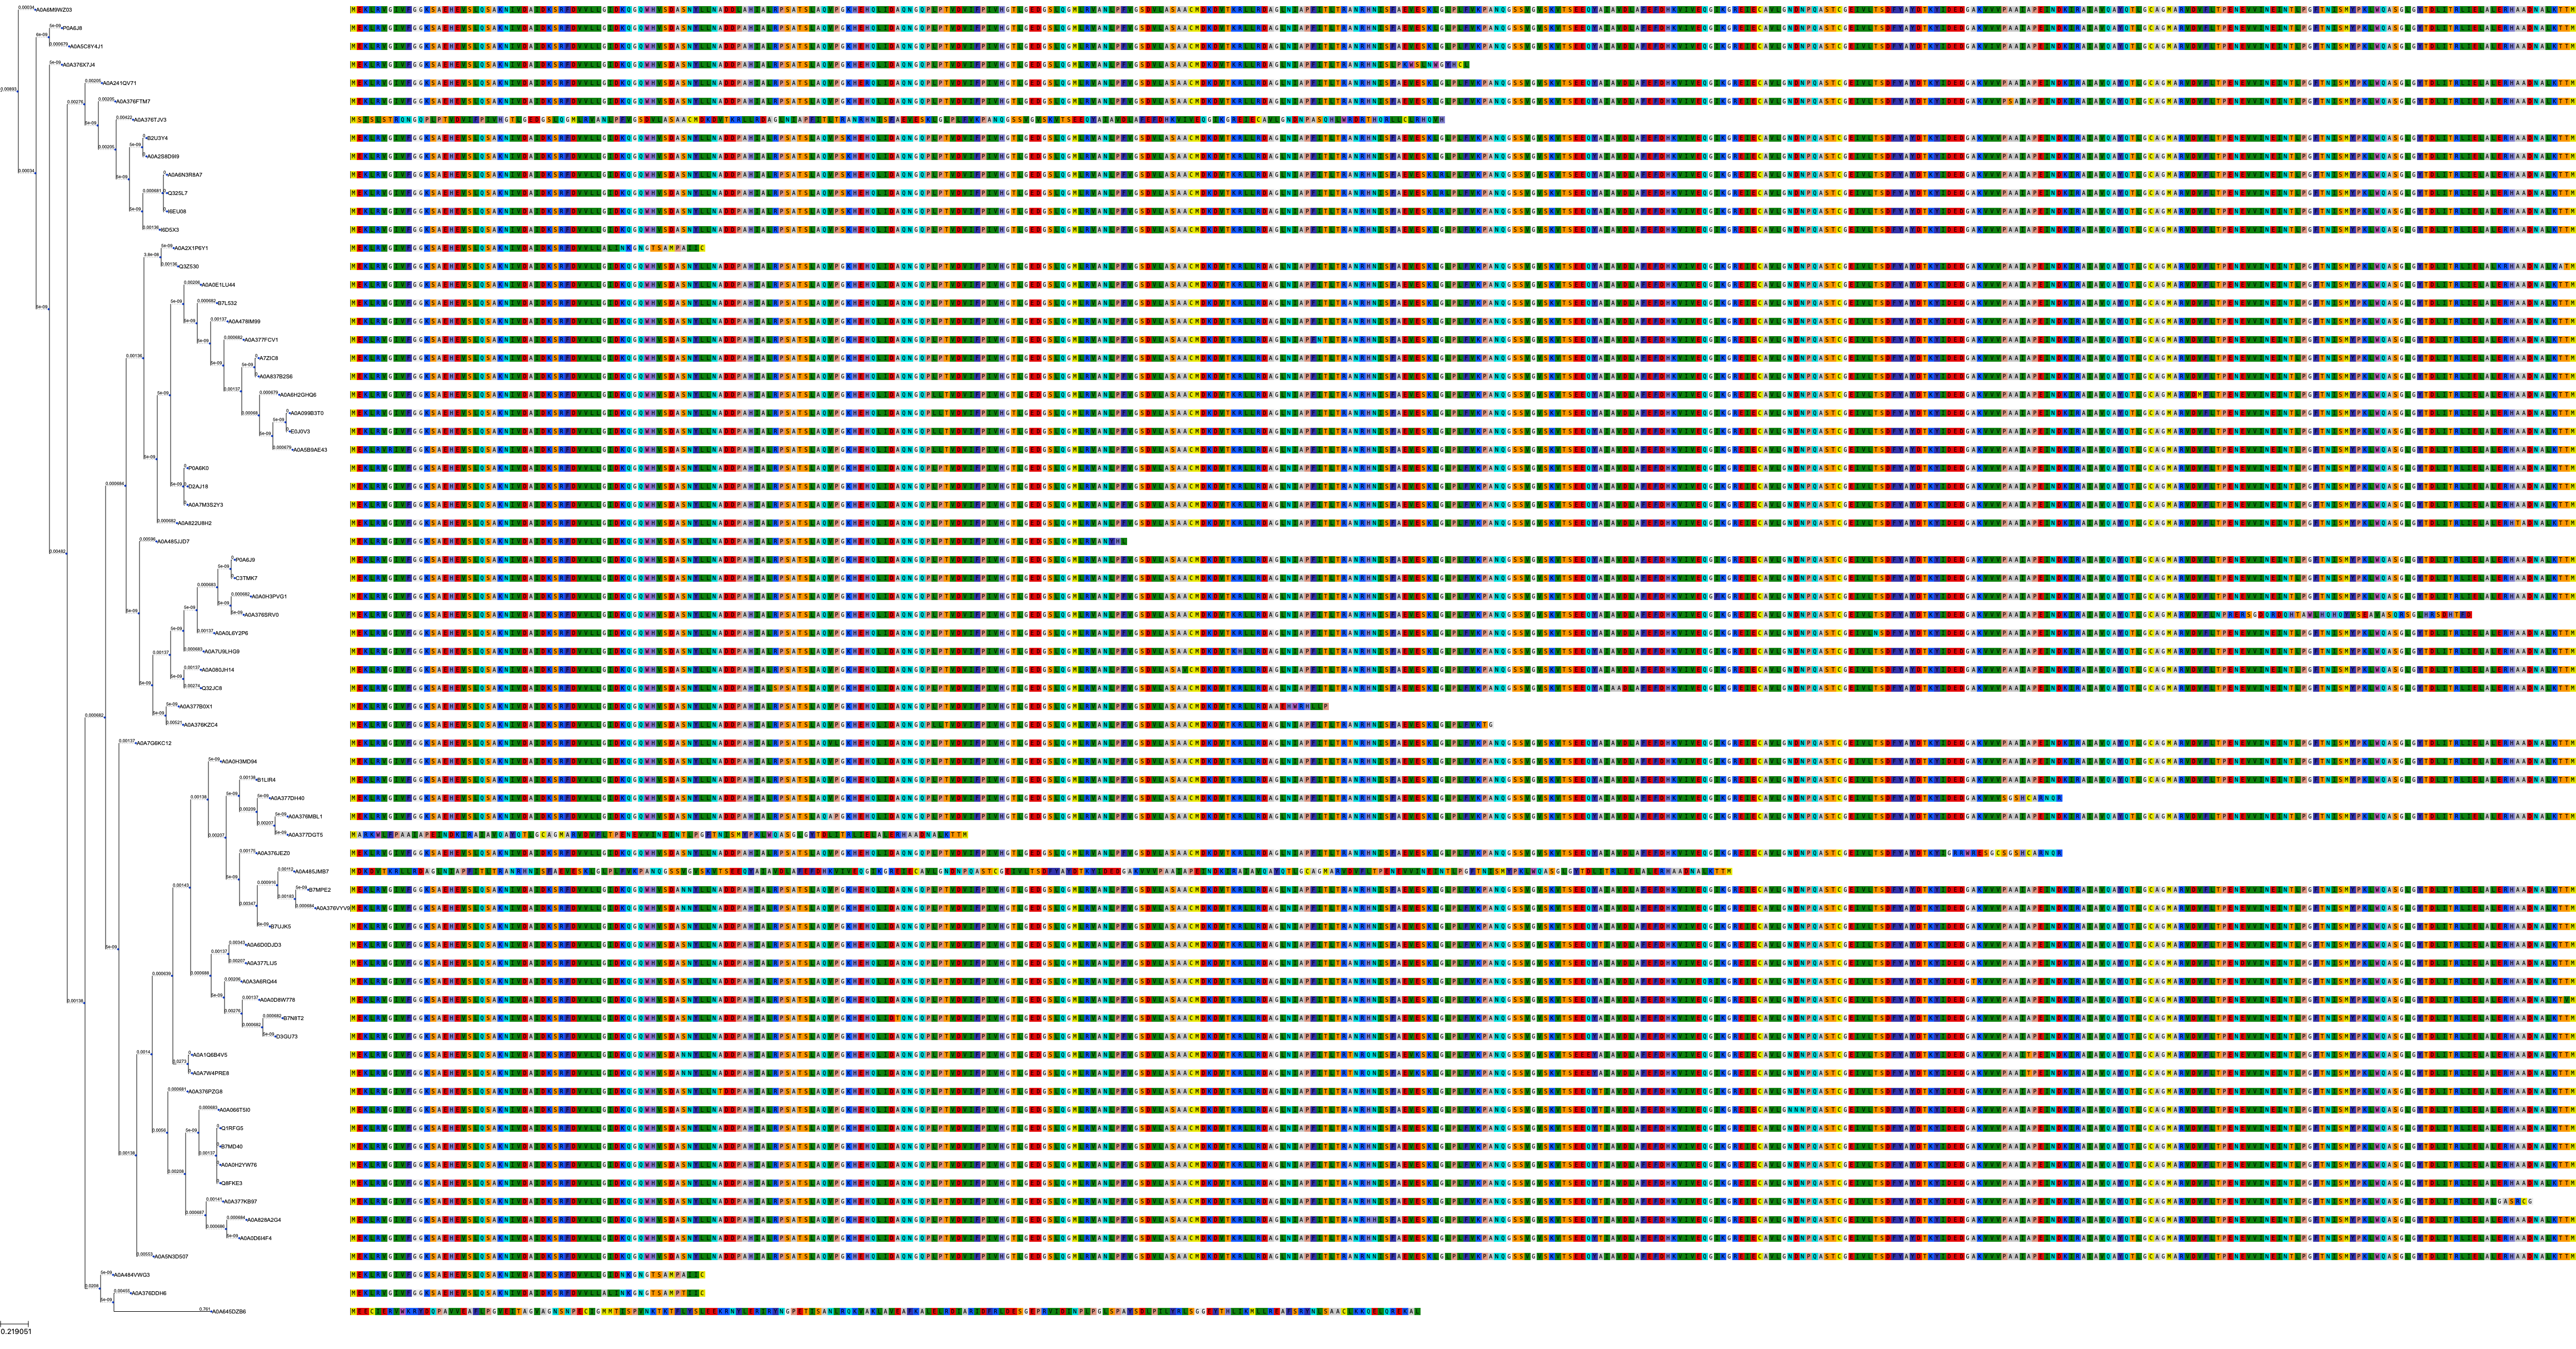

In [20]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces
from ete3 import SeqMotifFace, SequenceFace

# Load your tree
tree = Tree(f"{working_dir}/TREE/ddla_nucleotide.tree")
ecoli_ddla_leaf = tree.get_leaves_by_name("P0A6J8")[0]
ecoli_subtree = ecoli_ddla_leaf.up.up.up.up.up.up
# lca = ecoli_subtree.get_common_ancestor(t)
ecoli_subtree.set_outgroup( ecoli_subtree&"A0A6M9WZ03" )

# Function to add sequence alignment to tree leaves
def layout(node):
    if node.is_leaf():
        node.sequence = node.sequence.replace("-", "")
        # SeqMotifFace expects sequence as a string, alignment type (e.g., 'seq' or 'aa'), and other formatting options
        # seq_face = SeqMotifFace(node.sequence, seqtype='seq', motifs=[], gapcolor="black")
        seq_face = SequenceFace(node.sequence, seqtype='aa')
        faces.add_face_to_node(seq_face, node, column=0, position="aligned")

# Load sequences from the MSA into a dictionary (assuming a FASTA format for simplicity)
seqs = {}
for seq_record in SeqIO.parse(f"{working_dir}/MSA/DDLA_uniprot_sec_struct_04_filtered_alligned.fasta", "fasta"):
    seqs[seq_record.id] = str(seq_record.seq)


# Attach sequences to tree nodes
for n in ecoli_subtree.traverse():
    if n.name in seqs:
        n.add_features(sequence=seqs[n.name])

# Define tree style
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
ts.layout_fn = layout  # Use the layout function to add sequence alignment
ts.branch_vertical_margin = 20  # Adjust as needed for better visualization

# Show the tree
ecoli_subtree.render(file_name="%%inline", tree_style=ts)
# ecoli_subtree.show(tree_style=ts)